### **RGB Image Classification Capstone Project**

In [16]:
from torchgen.api.ufunc import kernel_name
from webencodings import labels

''' Import all Important Libraries '''
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

In [17]:
torch.manual_seed(40)
Device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print('Using Device :',Device)

Using Device : mps


### **Data Pipeline**

In [18]:
Transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5))
    ])

In [19]:
class CIFAR10Dataset(Dataset):
    def __init__(self, train=True, transform=None):
        super().__init__()
        self.dataset = datasets.CIFAR10(
            root='./data',
            train=train,
            download=True,
        )
        self.transform = transform
        self.classes = self.dataset.classes
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
            return image, label

In [20]:
Train_dataset = CIFAR10Dataset(train=True, transform=Transformation)
Test_dataset = CIFAR10Dataset(train=False, transform=Transformation)
print(len(Train_dataset))
print(len(Test_dataset))

50000
10000


In [21]:
example_image, example_label = Train_dataset[0]
print(f'image shape:{example_image.shape}\n label shape:{Train_dataset.classes[example_label]}')

image shape:torch.Size([3, 32, 32])
 label shape:frog


### **Train, Test DataLoader**

In [22]:
Train_DataLoader = DataLoader(
    dataset=Train_dataset,
    batch_size=4,
    shuffle=True
)

Test_DataLoader = DataLoader(
    dataset=Test_dataset,
    batch_size=4 ,
    shuffle=False
)

### ***Convo > Pooling > Relu > Linear > Flatten***

In [23]:
class MyImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=256,
            kernel_size=3,
            padding=1
        )
        self.pooling = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=3,
            padding=1
        )

        self.Linear1 = nn.Linear(512 * 8 * 8, 128)
        self.Linear2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv Layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)

        # Second Conv Layer
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)

        # # Third Conv Layer
        # x =self.conv3(x)
        # x = self.relu(x)
        # x = self.pooling(x)


        # Flatten
        x = x.view(-1, 512 * 8 * 8)
        x = self.Linear1(x) # Layer 1
        x = self.relu(x)

        x = self.Linear2(x) # Layer 2


        return x

In [24]:
Model = MyImageNet().to(Device)
print(Model)

MyImageNet(
  (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear1): Linear(in_features=32768, out_features=128, bias=True)
  (Linear2): Linear(in_features=128, out_features=10, bias=True)
)


### **Train Model**

100%|██████████| 12500/12500 [03:07<00:00, 66.75it/s]


Epoch 1/20 Loss: 1.489


100%|██████████| 12500/12500 [03:26<00:00, 60.48it/s]


Epoch 2/20 Loss: 1.251


100%|██████████| 12500/12500 [03:22<00:00, 61.61it/s]


Epoch 3/20 Loss: 1.129


100%|██████████| 12500/12500 [03:15<00:00, 63.83it/s]


Epoch 4/20 Loss: 1.035


100%|██████████| 12500/12500 [03:16<00:00, 63.52it/s]


Epoch 5/20 Loss: 0.969


100%|██████████| 12500/12500 [03:21<00:00, 62.06it/s]


Epoch 6/20 Loss: 0.911


100%|██████████| 12500/12500 [03:12<00:00, 65.02it/s]


Epoch 7/20 Loss: 0.853


100%|██████████| 12500/12500 [03:24<00:00, 61.17it/s]


Epoch 8/20 Loss: 0.799


100%|██████████| 12500/12500 [03:24<00:00, 61.08it/s]


Epoch 9/20 Loss: 0.747


100%|██████████| 12500/12500 [03:09<00:00, 65.80it/s]


Epoch 10/20 Loss: 0.705


100%|██████████| 12500/12500 [03:09<00:00, 65.92it/s]


Epoch 11/20 Loss: 0.646


100%|██████████| 12500/12500 [03:12<00:00, 64.84it/s]


Epoch 12/20 Loss: 0.599


100%|██████████| 12500/12500 [03:04<00:00, 67.57it/s]


Epoch 13/20 Loss: 0.553


100%|██████████| 12500/12500 [09:15<00:00, 22.49it/s]  


Epoch 14/20 Loss: 0.507


100%|██████████| 12500/12500 [02:43<00:00, 76.32it/s]


Epoch 15/20 Loss: 0.466


100%|██████████| 12500/12500 [02:35<00:00, 80.40it/s]


Epoch 16/20 Loss: 0.431


100%|██████████| 12500/12500 [02:44<00:00, 76.10it/s]


Epoch 17/20 Loss: 0.396


100%|██████████| 12500/12500 [02:24<00:00, 86.48it/s]


Epoch 18/20 Loss: 0.371


100%|██████████| 12500/12500 [02:40<00:00, 78.04it/s]


Epoch 19/20 Loss: 0.341


100%|██████████| 12500/12500 [02:34<00:00, 80.65it/s]


Epoch 20/20 Loss: 0.317


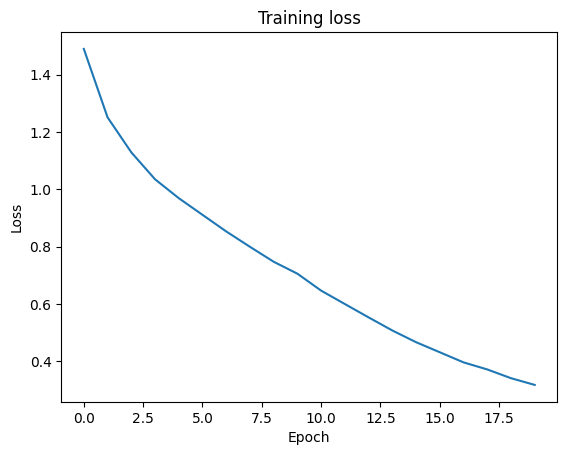

In [25]:
from tqdm import tqdm
import os
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)
num_epochs = 20
criterion_losses = []
for epoch in range(num_epochs):
    Model.train()
    running_loss = 0.0
    batch=0


    for images, label in tqdm(Train_DataLoader):
        images, label = images.to(Device), label.to(Device)
        batch += 1
        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(Train_DataLoader)
    criterion_losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs} Loss: {epoch_loss:.3f}')

import matplotlib.pyplot as plt
plt.plot(criterion_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

### **Model Evaluation**

In [26]:
Model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, label in Test_DataLoader:
        images, label = images.to(Device), label.to(Device)
        outputs = Model(images)
        _, Predict = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (Predict == label).sum().item()
# KL Divergence
import numpy as np
from scipy.stats import entropy
# predict, _ = np.histogram(Predict, bins=50, density=True)
# outputs, _ = np.histogram(outputs, bins=50, density=True)
# kl_divergence = entropy(predict+1e-10, outputs+1e-10)
best_model = 0
Accuracy = 100 * correct / total
print(f'Mode Accuracy: {Accuracy:.3f}')
if Accuracy > best_model:
    best_model = Accuracy
    torch.save(Model.state_dict(), 'Best_Model.pth')


Mode Accuracy: 68.330
